# PCA and senate voting data


In this problem, we are given the $m \times n$ data matrix $X$ with entries in $\{-1,0,1\}$, where each row corresponds to a senator and each column to a bill. We first import this data, print some relevant values, and normalize it as necessary to ready it for further computation.

To run this code, you'll need a number of standard Python libraries, all of which are installed. Simply run the following cell to import them.

### Places you will need to modify this code are enclosed in a $\texttt{#TODO}$ block. You should not need to modify code outside these blocks to complete the problems. Questions that you are expected to answer in text are marked in <font color='red'>red</font>. For solution files, solutions will be presented in <font color='blue'>blue</font>.

In [1]:
# import the necessary packages for data manipulation, computation and PCA 
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline

np.random.seed(10)

In [2]:
# import the data matrix
senator_df =  pd.read_csv('senator_data_pca/data_matrix.csv')
affiliation_file = open('senator_data_pca/politician_labels.txt', 'r')
affiliations = [line.split('\n')[0].split(' ')[1] for line in affiliation_file.readlines()]
X = np.array(senator_df.values[:, 3:].T, dtype='float64') # transpose to get senators as rows
print('X.shape: ', X.shape)
n = X.shape[0] # number of senators
m = X.shape[1] # number of bills

X.shape:  (100, 542)


We observe that the number of rows, $n$, is the number of senators and is equal to 100. The number of columns, $m$, is the number of bills and is equal to 542. 

In [3]:
# print an example row of the data matrix
typical_row = X[0,:]
print(typical_row.shape)
print(typical_row)

(542,)
[ 1.  1.  1. -1. -1.  1.  1.  1.  1. -1.  1. -1. -1.  1.  1. -1.  1.  1.
  1.  1.  1. -1.  1.  1.  1. -1.  1. -1.  1.  1.  1.  1.  1. -1.  1. -1.
 -1. -1. -1.  1.  1. -1. -1. -1. -1.  1.  1.  1. -1.  1.  1. -1.  1.  1.
 -1.  1.  1.  1.  1. -1.  1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1. -1.  0. -1.  1.  1.  1. -1. -1.  1.  1. -1. -1.  1.  1.  1. -1.
  1. -1.  1. -1.  1.  1. -1. -1. -1.  1.  1.  1. -1. -1. -1. -1. -1. -1.
  1. -1.  1.  1. -1. -1. -1.  1. -1.  1. -1.  1.  0.  0.  1.  1. -1.  1.
  1. -1.  1.  1. -1.  1. -1. -1.  1.  1.  1.  1.  0. -1. -1.  1.  1. -1.
  1.  1.  1.  1.  1.  0.  1.  0.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.
 -1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1. -1. -1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.  1.  1.  1. -1.
  1.  1.  0.  1.  0. -1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.

A row of $X$ consists of 542 entries -1 (senator voted against), 1 (senator voted for), or 0 (senator abstained), one for each bill. 

In [4]:
# print an example column of the data matrix
typical_column = X[:,0]
print(typical_column.shape)
print(typical_column)

(100,)
[ 1.  1.  1.  1.  1.  1.  1. -1.  1. -1.  1. -1.  1. -1. -1. -1.  1.  1.
 -1.  1.  1. -1.  1. -1.  1.  1.  1. -1. -1.  1.  1.  1. -1.  1.  1.  1.
 -1. -1. -1. -1.  1. -1. -1.  1.  1. -1. -1. -1. -1. -1.  1.  1. -1. -1.
  1.  1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1. -1. -1. -1.  1. -1. -1.
  1. -1. -1.  1.  1.  1. -1. -1. -1.  1.  1. -1.  1. -1.  1.  1.  1. -1.
 -1. -1. -1. -1.  1.  1.  1. -1. -1. -1.]


A column of $X$ consists of 100 entries in \{-1, 0, 1\}, one for each senator that voted on the bill.

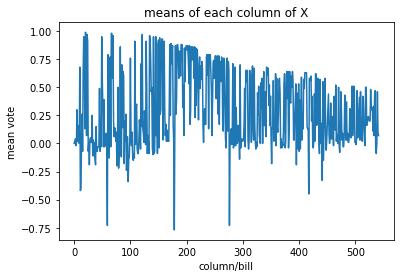

In [5]:
# compute the mean vote on each bill
X_mean = np.mean(X, axis = 0)
plt.plot(X_mean)
plt.title('means of each column of X')
plt.xlabel('column/bill')
plt.ylabel('mean vote')
plt.show()

We observe that the mean of the columns is not zero, so we center the data by subtracting the mean of each bill's vote from its respective column. 

We then plot the mean again, notice the labels on the axes. 

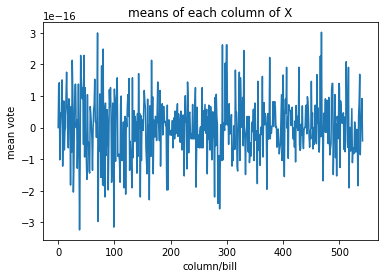

In [6]:
# center the data matrix
X_original = X.copy() # save a copy for part (d) and (e)
X = X - np.mean(X, axis = 0)
centered_X_mean = np.mean(X, axis = 0)
plt.plot(centered_X_mean)
plt.title('means of each column of X')
plt.xlabel('column/bill')
plt.ylabel('mean vote')
plt.show()

## a) Maximizing ${\rm var}(f(X,a))$

In this problem, you are asked to find a unit norm vector $a \in R^m$ that maximizes the variance, given by ${\rm var}(f(X,a))$.

We first provide a function to calculate the scores, $f(X,a)$.

In [7]:
# define score function
def f(X, a):
    return np.matmul(X,a)

Before we calculate the $a$ that maximizes variance, let's observe what the scalar projections on a random vector looks like.

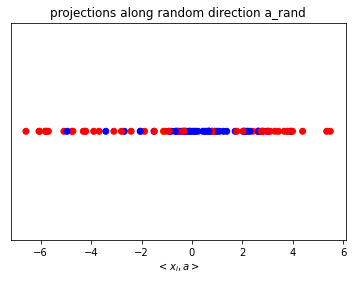

variance along random direction a_rand:  8.4981


In [8]:
# generate a random direction and normalize the vector
a_rand = np.random.rand(542,1)
a_rand = a_rand/np.linalg.norm(a_rand)

# compute associated scores along a_rand
scores_rand = f(X, a_rand)

# visualize the scores along a_rand, coloring them by party affiliation
plt.scatter(scores_rand, np.zeros_like(scores_rand), c=affiliations)
plt.title('projections along random direction a_rand')
plt.xlabel('$<x_i, a>$')
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)
plt.show()

print('variance along random direction a_rand: ', '%.4f'%scores_rand.var())

Note here that projecting along the random vector $\texttt{a_rand}$ does not explain much variance at all — data points are clustered together and intermixed across parties. It is clear that this direction does not give us any information about the senators' affiliations.

#### Fill in the code below to find direction $\texttt{a_1}$ that maximizes variance. Note that this will be the first principal component of $\texttt{X}$ .

first principal component (a_1) shape: (542, 1)


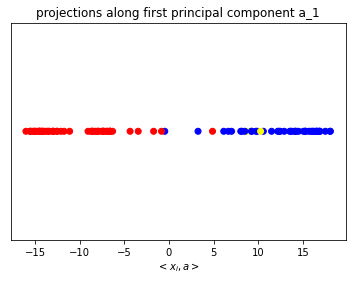

variance along first principal component:  149.7490


In [9]:
################################################################################
### TODO: Calculate a_1, the first principal component of X.
# Hint: The PCA package imported from sklearn.decomposition will be useful here, 
# in particular the function pca.fit(). What should the dimensions of a_1 be?
pca = PCA(n_components=1)
pca.fit(X)
a_1 = pca.components_.T# replace w/ first principal component


print("first principal component (a_1) shape: {}".format(a_1.shape))


### end TODO
################################################################################

a_1 = a_1/np.linalg.norm(a_1)
# compute and visualize the scores along a_1
scores_a_1 = f(X, a_1)

plt.scatter(scores_a_1, np.zeros_like(scores_a_1), c=affiliations)
plt.title('projections along first principal component a_1')
plt.xlabel('$<x_i, a>$')
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)
plt.show()

print('variance along first principal component: ', '%.4f'%scores_a_1.var())

If you computed $\texttt{a_1}$ correctly, you should observe that the variance is much higher than the $\texttt{a_rand}$ projection (at least 10 times higher), and that blue and red dots are now spread in two clusters. 

Why does this make sense? The first principal component is the direction along which data varies most, and that is often along party lines. You just found a mathematical model for partisanship!

## b) Comparison to party averages

We observed above that the direction of maximum variance appears to be determined by party alignment; we now want to quantify how true that is by computing variance along vectors that describe the average position of each party. Specifically, we will compute variance along the following two vectors:

- $\texttt{a_mean_red}$: unit vector along the mean of rows of $\texttt{X}$ corresponding to ‘Red’ senators
- $\texttt{a_mean_blue}$: unit vector along the mean of rows of $\texttt{X}$ corresponding to ‘Blue’ senators

#### Fill in the code as indicated below to calculate these values and compute their relationships to $\texttt{a_1}$ and each other, then answer the interpretation question that follows.

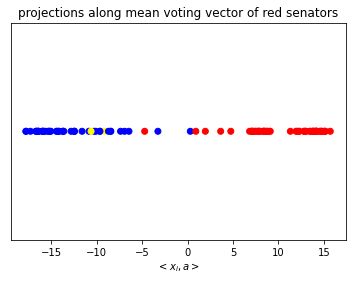

variance along mean voting vector of red senators:  148.8070
dot product of a_mean_red and a_1:  -0.9965
angle between a_mean_red and a_1 (degrees):  175.2294


In [10]:
## ### TODO: Calculate mu_red, the array of dimension (542, 1) whose values 
### are the mean across rows of X corresponding to 'Red' senators only.
# Hint: Print out the 'affiliations' variable and observe its contents.
# print(len(affiliations))
#print(affiliations)
# print(X.shape)

bool_array = np.array(affiliations) == 'Red'
X_red = X[bool_array]
mu_red = np.mean(X_red, axis = 0) #TODO replace mu_red - make sure it has size (541,1) not (542,)

### end TODO
################################################################################

# normalize the vector to generate unit a_mean_red
a_mean_red = mu_red/np.linalg.norm(mu_red)

# compute and visualize the scores along a_mean_red
scores_mean_red = f(X, a_mean_red)

plt.scatter(scores_mean_red, np.zeros_like(scores_mean_red), c=affiliations)
plt.title('projections along mean voting vector of red senators')
plt.xlabel('$<x_i, a>$')
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)
plt.show()

print('variance along mean voting vector of red senators: ', '%.4f'%scores_mean_red.var())

# check angle between mean voting vector of red senators and the first principal component
dot_product_red_a1 = float(np.dot(a_mean_red.T, a_1))
angle_red_a1 = np.arccos(dot_product_red_a1/(np.linalg.norm(a_mean_red)*np.linalg.norm(a_1)))*180/np.pi

print('dot product of a_mean_red and a_1: ', '%.4f'%dot_product_red_a1)
print('angle between a_mean_red and a_1 (degrees): ', '%.4f'%angle_red_a1)

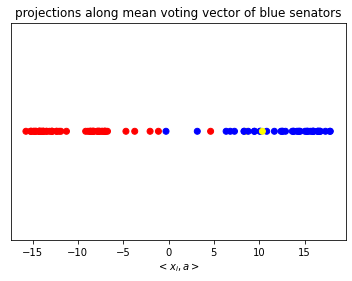

variance along mean voting vector of blue senators:  148.9088
dot product of a_mean_blue and a_1:  0.9970
angle between a_mean_blue and a_1 (degrees):  4.4517


In [11]:
################################################################################
### TODO: Calculate mu_blue, the array of dimension (542, 1) whose values 
### are the mean across rows of X corresponding to 'RBlue' senators only.
# Hint: Print out the 'affiliations' variable and observe its contents.
# print(len(affiliations))
# print(affiliations)

bool_array = np.array(affiliations) == 'Blue'
X_blue = X[bool_array]
mu_blue = np.mean(X_blue, axis = 0)  # TODO 

### end TODO
################################################################################

# normalize the vector to generate unit a_mean_blue
a_mean_blue = mu_blue/np.linalg.norm(mu_blue)

# compute and visualize the scores along a_mean_blue
scores_mean_blue = f(X, a_mean_blue)

plt.scatter(scores_mean_blue, np.zeros_like(scores_mean_blue), c=affiliations)
plt.title('projections along mean voting vector of blue senators')
plt.xlabel('$<x_i, a>$')
cur_axes = plt.gca()
cur_axes.axes.get_yaxis().set_visible(False)
plt.show()

print('variance along mean voting vector of blue senators: ', '%.4f'%scores_mean_blue.var())

# check angle between mean voting vector of red senators and the first principal component
dot_product_blue_a1 = float(np.dot(a_mean_blue.T, a_1))
angle_blue_a1 = np.arccos(dot_product_blue_a1/(np.linalg.norm(a_mean_blue)*np.linalg.norm(a_1)))*180/np.pi

print('dot product of a_mean_blue and a_1: ', '%.4f'%dot_product_blue_a1)
print('angle between a_mean_blue and a_1 (degrees): ', '%.4f'%angle_blue_a1)


In [12]:
# compute dot product of and angle between a_mean_red and a_mean_blue:
dot_product_blue_red = float(np.dot(a_mean_blue.T, a_mean_red))
angle_blue_red = np.arccos(dot_product_blue_red)*180/np.pi

print('dot product of a_mean_blue and a_mean_red: ', '%.4f'%dot_product_blue_red)
print('angle between a_mean_blue and a_mean_red (degrees): ', '%.4f'%angle_blue_red)


dot product of a_mean_blue and a_mean_red:  -0.9992
angle between a_mean_blue and a_mean_red (degrees):  177.7589


### <font color='red'>TODO: Interpretation</font>
#### <font color='red'> Comment on the relationships between $\texttt{a_1}$, $\texttt{a_mean_red}$, and $\texttt{a_mean_blue}$ above based on their dot products and relative angles. What do these values tell you about how senators of a given party are likely to vote?
</font>

#### <font color='blue'> [YOUR ANALYSIS HERE]
* Relationship between $\texttt{a_1}$ and $\texttt{a_mean_red}$\
The dot product of $\texttt{a_1}$ and $\texttt{a_mean_red}$ is -0.9965, which is close to -1. Moreover, the angle between $\texttt{a_1}$ and $\texttt{a_mean_red}$ is 175.2294, which is close to 180. Therefore, we can observe that they point in opposite directions.
    
* Relationship between $\texttt{a_1}$ and $\texttt{a_mean_blue}$\
The dot product of $\texttt{a_1}$ and $\texttt{a_mean_blue}$ is 0.9970, which is close to 1. Moreover, the angle between $\texttt{a_1}$ and $\texttt{a_mean_blue}$ is 4.4517, which is close to. Therefore, we can observe that they point in the same direction.
    
* Relationship between $\texttt{a_mean_red}$ and $\texttt{a_mean_blue}$\
Similarly to the first relationship, the dot product of $\texttt{a_mean_red}$ and $\texttt{a_mean_blue}$ is -0.9992, which is close to -1. Moreover, the angle between $\texttt{a_mean_red}$ and $\texttt{a_mean_blue}$ is 177.7589, which is close to 180. Therefore, we can observe that they point in opposite directions.
     
  
From above numbers, it can be observed that:
* Senators of a specific party tend to have similar voting patterns
* Many blue senators vote for bills that red senators vote against and vice versa. 
* From $\texttt{a_mean_red}$ and $\texttt{a_mean_blue}$, we can observe that there is a correlation between positive score and a tendency to agree with the red and blue party, respectively.
    
Since $\texttt{a_1}$ is very similar to $\texttt{a_mean_blue}$ and nearly the opposite of $\texttt{a\_mean\_red}$, we can interpret $\texttt{a_1}$ as how much a given senator has in common with senators of the blue party. That is, a senator whose corresponding projection on $\texttt{a_1}$ is positive is likely to be a blue senator and vice versa.
</font>

## c) Computing total variance 

We now wish to observe the variance of the data along the first two principal component axes.

#### Fill in the code below to calculate the total variance of the data along the first two principal components $\texttt{a_1}$ and $\texttt{a_2}$ and to plot the data on the corresponding axes.

In [13]:
# calculate C (see LaTeX problem for description)
X_bar = np.matmul(X.T, X)/n

################################################################################
### TODO: Calculate the total variance across a_1 and a_2.
# Hint: This value is equal to the sum of the two largest eigenvalues of X_bar.


u, s, vt = np.linalg.svd(X_bar)
total_variance = s[0] + s[1] 

### end TODO
################################################################################

print('total variance accounted for by first two principal components: ', '%.4f'%total_variance)


total variance accounted for by first two principal components:  175.1712


Next, we calculate and plot the projection onto the plane spanned by the first two principal components.

(100, 2)


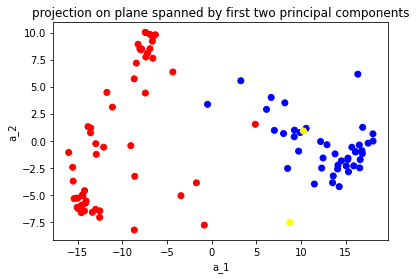

In [14]:
# calculate projected data matrix and observe its shape
pca = PCA(n_components=2)
projected = pca.fit_transform(X)
print(projected.shape)

# plot projected data matrix
plt.scatter(projected[:, 0], projected[:, 1], c=affiliations)
plt.xlabel('a_1')
plt.ylabel('a_2')
plt.title('projection on plane spanned by first two principal components')
plt.show()

## d) Finding bills that are the most/least contentious

We now wish to observe which bills are the most and least contentious — i.e., those for which most senators voted unanimously, and those for which support was most varied. We consider two possible ways of quantifying this relationship mathematically.

### Approach 1: Compute the variance of the columns of $X$

One option is to compute the variance of each column of $X$ — each of which corresponds to a particular bill — and use this variance as a measure of "contentiousness" (i.e., the more contentious a bill, the higher its variance in terms of senator vote count). Note that the variance of a particular bill in column $j$ can be viewed as the variance of scores along $e_j$, where $e_j$ is a basis vector whose $j^\textrm{th}$ entry is 1 and all others 0.

#### Fill in the code below to calculate the variance of $X$, extract the most and least contentious bills, and plot their vote counts, commenting on your results where indicated.

In [15]:
# calculate the variance of each column
list_variances = X.var(0)
bills = senator_df['bill_type bill_name bill_ID'].values

################################################################################
### TODO: Compute sorted_idx_variances, an np.array of shape (542,) containing
### integer entries that are the indices of variance scores in list_variances in
### decreasing order of variance. For example, if list_variances = [1, 3, 2, 4], 
### then sorted_idx_variances = np.array([3,1,2,0]).
# Hint: Use np.argsort().

sorted_idx_variances = np.argsort(list_variances)
### end TODO
################################################################################

print(sorted_idx_variances.shape)

(542,)


Using this sorted index, we can now plot the vote counts for the top 5 highest and lowest variance bills.

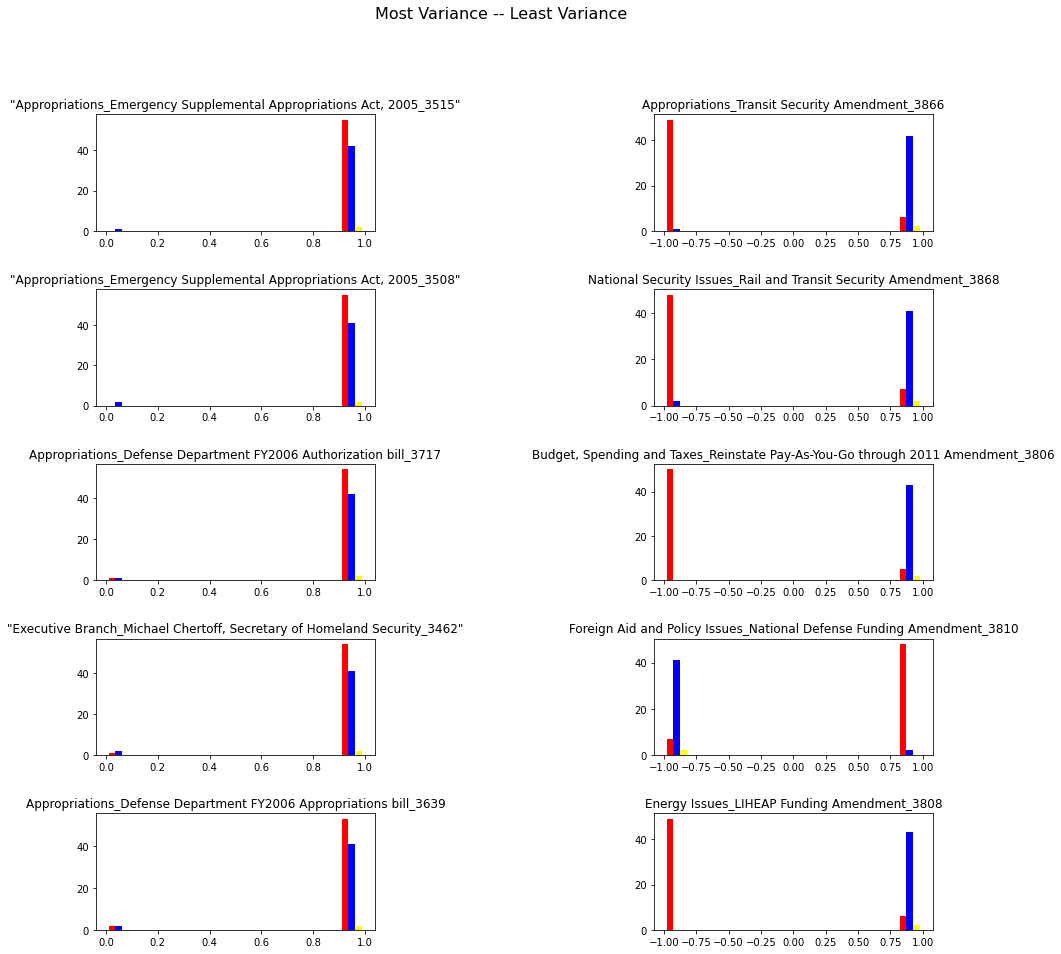

In [16]:
# retrieve the bills with the 5 highest and lowest variances
top_5 = [bills[sorted_idx_variances[i]] for i in range(5)]
bot_5 = [bills[sorted_idx_variances[-1-i]] for i in range(5)]

# set up figure with all desired subplots
fig, axes = plt.subplots(5,2, figsize=(15,15))

# plot highest variance bills
for i in range(5): 
    idx = sorted_idx_variances[i]
    
    # retrieve vote counts from original uncentered data matrix
    X_red_c = X_original[np.array(affiliations) == 'Red',idx]
    X_blue_c = X_original[np.array(affiliations) == 'Blue',idx]
    X_yellow_c = X_original[np.array(affiliations) == 'Yellow',idx]
    
    axes[i,0].hist([X_red_c, X_blue_c, X_yellow_c], color = ['red', 'blue', 'yellow'])
    axes[i,0].set_title(bills[idx])

# plot lowest variance bills
for i in range(1,6): 
    idx2 = sorted_idx_variances[-i]
    
    # retrieve vote counts from original uncentered data matrix
    X_red_c2 = X_original[np.array(affiliations) == 'Red',idx2]
    X_blue_c2 = X_original[np.array(affiliations) == 'Blue',idx2]
    X_yellow_c2 = X_original[np.array(affiliations) == 'Yellow',idx2]
    
    axes[i-1,1].hist([X_red_c2, X_blue_c2, X_yellow_c2], color = ['red', 'blue', 'yellow'])
    axes[i-1,1].set_title(bills[idx2])

plt.subplots_adjust(hspace=0.5, wspace = 1)    
fig.suptitle('Most Variance -- Least Variance', fontsize=16)
plt.show()


### <font color='red'>TODO: Interpretation</font>
#### <font color='red'> Comment on the voting trends you observe in the plots above. In general, if a vote is {contentious, uncontentious}, what do you expect the plots to look like?
</font>

#### <font color='blue'> [YOUR ANALYSIS HERE]
    Senators from both parties tend to vote in opposing directions on contentious votes. That is, red senators are more likely to vote against blue senators' bills, and vice versa. Senators from both parties with uncontentious bills, on the other hand, support almost unanimously.
</font>

We now consider a second possible metric for "contentiousness" and perform a similar computation.

### Approach 2: Project each bill's basis vector $e_j$ onto $a_1$

Instead of defining the most (least) contentious bills as those the of highest (lowest) variance, we can define them as those whose corresponding basis vectors $e_j$ remain the largest (smallest) in magnitude when projected onto the first principal component $a_1$. Note that this is equivalent to computing the inner product of $a_1$ with each $e_j$ and choosing those with highest (lowest) absolute value. Since we are taking inner products with standard basis vectors, this is equivalent to simply choosing the values of $a_1$ with the largest (smallest) magnitude! (Think about what this implies about the definition of $a_1$.)

We compute and plot the 5 most and least contentious bills by this metric below.

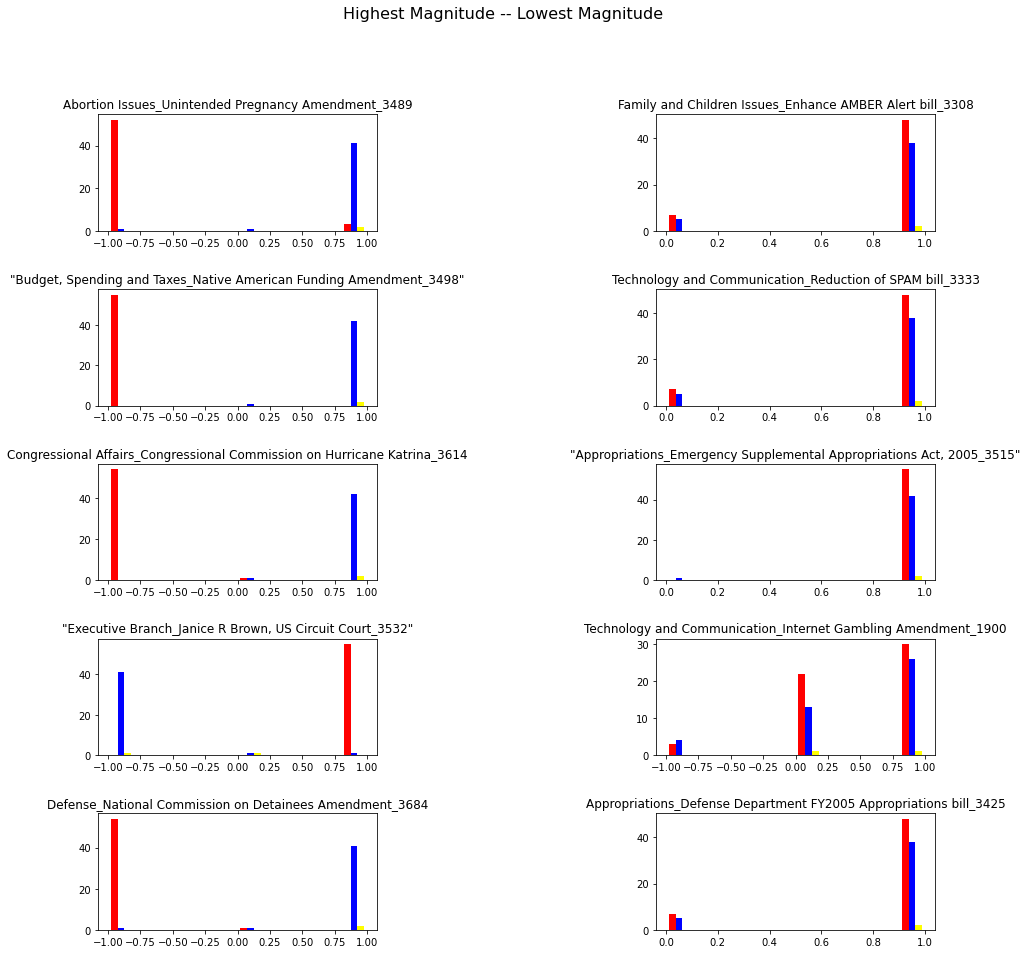

In [17]:
# flatten the first principal component a_1, then compute its absolute value
a_1_flat = np.ndarray.flatten(a_1)
abs_a_1 = np.abs(a_1_flat)

# find sorted indices of a_1 entry magnitudes in decreasing order
sorted_idxes = np.argsort(-abs_a_1)

# retrieve the bills with the 5 highest and lowest magnitudes
top_5_a1 = [bills[sorted_idxes[i]] for i in range(5)]
bot_5_a1 = [bills[sorted_idxes[-1-i]] for i in range(5)]

# set up figure with all desired subplots
fig, axes = plt.subplots(5,2, figsize=(15,15))

# plot highest magnitude bills
for i in range(5): 
    idx = sorted_idxes[i]

    # retrieve vote counts from original uncentered data matrix
    X_red_c = X_original[np.array(affiliations) == 'Red',idx]
    X_blue_c = X_original[np.array(affiliations) == 'Blue',idx]
    X_yellow_c = X_original[np.array(affiliations) == 'Yellow',idx]
    
    axes[i,0].hist([X_red_c, X_blue_c, X_yellow_c], color = ['red', 'blue', 'yellow'])
    axes[i,0].set_title(bills[idx])

# plot lowest magnitude bills
for i in range(1,6): 
    idx2 = sorted_idxes[-i]

    # retrieve vote counts from original uncentered data matrix
    X_red_c2 = X_original[np.array(affiliations) == 'Red',idx2]
    X_blue_c2 = X_original[np.array(affiliations) == 'Blue',idx2]
    X_yellow_c2 = X_original[np.array(affiliations) == 'Yellow',idx2]
    
    axes[i-1,1].hist([X_red_c2, X_blue_c2, X_yellow_c2], color = ['red', 'blue', 'yellow'])
    axes[i-1,1].set_title(bills[idx2])

plt.subplots_adjust(hspace=0.5, wspace = 1)    
fig.suptitle('Highest Magnitude -- Lowest Magnitude', fontsize=16)
plt.show()


### <font color='red'>TODO: Interpretation</font>
#### <font color='red'> Comment on the voting trends you observe in the plots above and how they compare to those calculated using variance. In general, if a vote is {contentious, uncontentious}, what do you expect the plots to look like?
</font>

#### <font color='blue'> [YOUR ANALYSIS HERE]
    General, senators from both parties tend to vote in opposing directions on contentious votes. That is, red senators are more likely to vote against blue senators' bills, and vice versa. Senators from both parties with uncontentious bills, on the other hand, support almost unanimously. We can observe that this is exactly the same as the variance-based method.
</font>

Lastly, let us observe how many bills are considered most (least) contentious by both approaches.

In [18]:
# calculate number of bills considered most and least contentious by both approaches
print('number of common bills in top 5: ', len(np.intersect1d(top_5 ,top_5_a1)))
print('number of common bills in bottom 5: ', len(np.intersect1d(bot_5 ,bot_5_a1)))


number of common bills in top 5:  0
number of common bills in bottom 5:  0


### <font color='red'>TODO: Interpretation</font>
#### <font color='red'> Are the bills computed by the two methods the same? Why or why not?
</font>

#### <font color='blue'> [YOUR ANALYSIS HERE]
    We can see that both methodologies agree that just one bill is the least contentious. As a result of their varied definitions of "contentiousness," the two methodologies are vastly different in terms of "contentiousness."
</font>

## e) Finding extreme senators

Lastly, let us return to our initial definition of $f(X,a)$, which assigns each senator a score. We will now use this value computed along the first principal component $a$ to assign the following classifications to our senators:

- Senators with the top 10 most positive scores and top 10 most negative scores are classified as *most extreme*.
- Senators with the 20 scores closest to 0 are classified as *least extreme*.

In the final subproblem, we observe these scores and how they relate to party affiliation.

We first compute the most extreme senators:

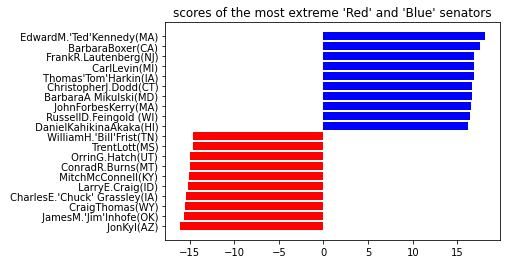

In [19]:
# extract senator names
senators = senator_df.columns.values[3:]

# compute and sort senators scores and corresponding affiliations
senator_scores = f(X,a_1)[:,0]
complete_sort_indices = np.argsort(senator_scores)
sort_indices = np.hstack([complete_sort_indices[:10], complete_sort_indices[-11:-1]])
senators_sorted = senators[sort_indices]
senator_scores_sorted = senator_scores[sort_indices]
affiliations = np.array(affiliations)
affiliations_sorted = affiliations[sort_indices]

plt.barh(y = senators_sorted, width = senator_scores_sorted, color = affiliations_sorted)
plt.title('scores of the most extreme \'Red\' and \'Blue\' senators')
plt.show()


And the least extreme senators:

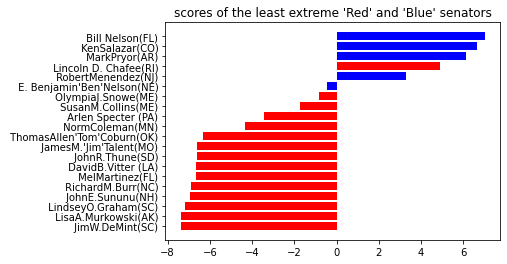

In [20]:
# compute and sort senators scores and corresponding affiliations
senator_scores = f(X,a_1)[:,0]
complete_sort_indices = np.argsort(np.abs(senator_scores))[:20]
senator_scores_le= senator_scores[complete_sort_indices]
senators_le = senators[complete_sort_indices]
affiliations = np.array(affiliations)
affiliations_le = affiliations[complete_sort_indices]
sort_indices = np.argsort(senator_scores_le)
senators_sorted = senators_le[sort_indices]
senator_scores_sorted = senator_scores_le[sort_indices]
affiliations_sorted = affiliations_le[sort_indices]

plt.barh(y = senators_sorted, width = senator_scores_sorted, color = affiliations_sorted)
plt.title('scores of the least extreme \'Red\' and \'Blue\' senators')
plt.show()

### <font color='red'>TODO: Interpretation</font>
#### <font color='red'> Comment on the sign of senators' scores and what they say about party affiliation for both the most and least extreme senators. (Bonus: Can you locate some of the senators on your PCA projection plot in part (a) above?)
</font>

#### <font color='blue'> [YOUR ANALYSIS HERE]
In both groups (most extreme and least extreme), the sign of senators' scores indicate correctly their party affiliation in the vast majority of cases. Generally, a positive score indicates affiliation with the blue party and vice versa. However, there might be two exceptions, which are Senators Chafee and Ben Nelson. Specifically, their scores contradict their party affiliations. Therefore, we can locate them on the plot in part (a) as the sole red and blue dot amongst the cluster of blue and red dots, respectively. 
</font>